# PyULN Dynamical Friction Automation Project

<a id='init'></a>
# Initialization and Program Settings

## Loading Packages



In [115]:
###### Do not touch
MinVersion = 14
MinHVersion = 6

import PyUltraLight_NBody as PyUL
import PyUL_Helper as PyULH

if (PyULH.S_version < MinHVersion) or (PyUL.S_version < MinVersion):
    raise RuntimeError("You need the latest integrator!")

import numpy as np
np.set_printoptions(suppress=True)

import math

import numba
import numexpr as ne

import pyfftw
import os
import sys
import multiprocessing
import numpy

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec
import matplotlib.animation
from matplotlib.offsetbox import AnchoredText

import scipy.fft

import h5py
from IPython.core.display import clear_output, display

%reload_ext autoreload
%autoreload 2
%matplotlib inline

print("==============================================")
print(f"PyULN: Axion Mass Used is {PyUL.axion_E} eV. This gives rise to:\n")

print(f"\
1 Mass Unit    = {PyUL.mass_unit:.5g} kg = {PyUL.convert_back(1,'solar_masses','m'):.4g} MSol\n\
1 Length Unit  = {PyUL.length_unit:.5g} m  = {PyUL.convert_back(1,'kpc','l'):.4g} kpc\n\
1 Time Unit    = {PyUL.time_unit:.5g} s  = {PyUL.convert_back(1,'Myr','t')/1000:.4g} Gyr\n\n\
1 Density Unit = {PyUL.mass_unit/PyUL.length_unit**3:.5g} kg/m^3 = {PyUL.mass_unit/PyUL.length_unit**3/PyUL.CritDens} Critical Density\n\
1 Speed Unit   = {PyUL.length_unit/PyUL.time_unit:.5g} m/s\n\
1 Energy Unit  = {PyUL.mass_unit*PyUL.length_unit**2/PyUL.time_unit**2:.5g} J\
")

PyULN: Axion Mass Used is 1e-22 eV. This gives rise to:

1 Mass Unit    = 4.4304e+36 kg = 2.227e+06 MSol
1 Length Unit  = 1.1838e+21 m  = 38.36 kpc
1 Time Unit    = 2.3694e+18 s  = 75.13 Gyr

1 Density Unit = 2.6705e-27 kg/m^3 = 0.31 Critical Density
1 Speed Unit   = 499.62 m/s
1 Energy Unit  = 1.1059e+42 J


[**<font color=blue>Back to the Top</font>**](#root)
<a id='ULSettings'></a>
# PyULN Parameters

In [130]:
##================================================================
# Space Settings
resol = 256

# Time Settings
start_time = 0.0 # Should be given in the same units as duration. 

# Snapshot Settings A
save_number = 120
# Recommended Save Number Cap: 120
# Depending on resolution, this could require significant disk space.

# Runge-Kutta Steps for NBody
NS = 4 # 1,4,8,16,... NBody Integration Steps per ULD Step. 1 -> Euler

#Formats to save
hdf5 = False
npz = False
npy = True

#Data to save
#0
save_rho = False # Saves density data for entire 3D simulation grid
#1
save_psi = False # Saves ULD Phase Data in plane
#2
save_plane = False # Saves density data for plane z = 0
#3
save_energies = True # Saves integrated gravitational, kinetic and total energies as lists
#4
save_line = False # Saves density data for line y = 0, z = 0. Useful for examining intereference patterns. 
#5
save_testmass = True # Saves trajectory and 3-velocity of a test mass thrown into the system.   
#6
save_phi = False
#7
save_phi_plane = False
#8
save_gradients = True
#9
save_phase_plane = False

save_options = [save_rho,save_psi,save_plane,save_energies,save_line,save_testmass,save_phi,save_phi_plane,save_gradients,save_phase_plane]

SaveSizeEstimate = PyULH.SSEst(save_options,save_number,resol)

print('Estimated Save Size (GiB): %.02f' % SaveSizeEstimate )

#================================================================
# Do not touch
resol = (scipy.fft.next_fast_len(resol)) # Uses a nearby and faster resolution.
while resol%2:
    resol = scipy.fft.next_fast_len(resol+1)
    print(resol)
num_threads = multiprocessing.cpu_count()
print("Available CPU threads for this run: ",num_threads)

ULHelper: Saving NBody Gradient Data
ULHelper: Saving NBody Position Data
Estimated Save Size (GiB): 0.00
Available CPU threads for this run:  12


In [135]:
save_path = '2021_DF'  # Set Output Directory
PyULH.DSManagement(save_path)

2021_DF : The current size of the folder is 0.063 Mib
2021_DF : Do You Wish to Delete All Files Currently Stored In This Folder? [Y] 

Y
Folder Cleaned! 

2021_DF : Save Folder Created.


## Parameter Scan Run 1

100 Runs Organized as Such:

* 4 Velocities
* 5 Masses
* 5 Densities

### 4 Velocity Choices

    30,000 m/s
    60,000 m/s
    120,000 m/s
    240,000 m/s
    

### 5 Mass Choices

    0.5 Million MSol
    5 Million MSol
    30 Million MSol
    90 Million MSol
    270 Million MSol
    

### 5 Density Choice

    1 Milky Way Central Density
    1/3 Milky Way
    1/5 Milky Way
    3 Milky Way
    5 Milky Way
    
    

The grid subdivision is 0.0234 in specified units. This is 0.0006 code units.
The Smoothing factor is 3533.379


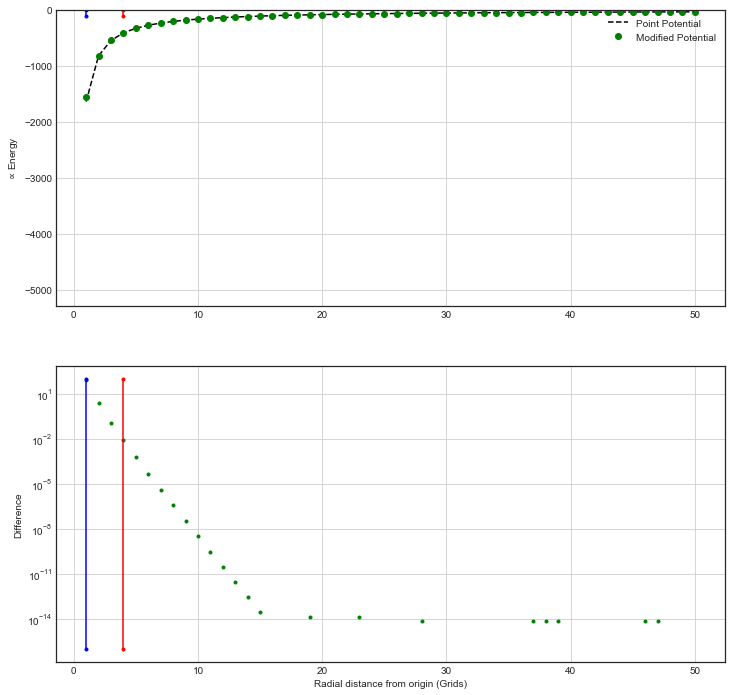

Generating Field Smoothing Report:
  The simulation runs on a 256^3 grid with total side length 0.2
  The simulation grid size is 0.0006 Code Units,
  

==========Grid Counts of Important Features=========

  Radius outside which the fields are practically indistinguishable (Grids): 4
  Modified Potential HWHM (Grids): 1


In [136]:
# Space Settings
length = 6 # 1 code unit is ~38 kpc x (1e-22/m_a)^0.5
length_units = 'kpc'  # Accepted units: 'm', 'km', 'pc', 'kpc', 'Mpc', 'ly', and '' for dimensionless units.

# Time Settings
duration = 1.4e-5 #1 code unit is ~70 Gyr (independent of axion mass assumption)
duration_units = ''  # Accepted units: 's', 'yr', 'kyr', 'Myr', and '' for dimensionless units

step_factor = 1

# Recommended Save Number Cap: 120
# Depending on resolution, this could require significant disk space.

##================================================================
## Other Flags
# Set units for soliton parameters
s_mass_unit = ''     #Accepted units: 'kg', 'solar_masses', 'M_solar_masses', and '' for dimensionless units
s_position_unit = '' #Accepted units: 'm', 'km', 'pc', 'kpc', 'Mpc', 'ly', and '' for dimensionless units
s_velocity_unit = '' #Accepted units: 'm/s', 'km/s', 'km/h', 'c', and '' for dimensionless units

# Rules ditto.
m_mass_unit = 'M_solar_masses'
m_position_unit = 'kpc'
m_velocity_unit = 'm/s'

# Density, if Uniform Background Flag is Set to 'True'
# 1 Code Density Unit is equal the universe's critical matter density, 2.67e-27 kg/m^3.
density_unit = '' # Accepted units: 'MSol/pc3', 'kg/m3', and '' for dimensionless units

##================================================================

LengthFS = PyUL.convert(length, length_units, 'l')

GridLenFS = LengthFS/(resol)

GridLenPC = PyUL.convert_back(GridLenFS,'pc','l')

print(f"The grid subdivision is {length/resol:.4f} in specified units. This is {GridLenFS:.4f} code units.")

central_mass = 0 # Not Implemented Anymore. Keep for code compatibility.
#================================================================
a = (2-PyUL.LW(np.exp(-2)))/LengthFS*resol
a = np.real(a)

print(f"The Smoothing factor is {a:.3f}")

PyULH.SmoothingReport(a,resol,LengthFS)

solitons = []
embeds = []
Uniform = True

Avg = False 

AvgDist = 1 # How far away the antennae are compared to grid length.
CentreWeight = 1 # The relative weight of central point to the antennae.

NCV, NCW = PyULH.PInit(Avg,AvgDist,CentreWeight)  


In [137]:
VPool = [3e4,6e4,1.2e5]
MPool = [3,9,27,81]
DPool = [2e10,4e10,8e10]

NTrials = len(VPool)*len(MPool)*len(DPool)

In [138]:
for ii in range(len(MPool)):
    
    for jj in range(len(DPool)):
        
        for kk in range(len(VPool)):

            particles = [[MPool[ii],[0,-0.1,0],[0,VPool[kk],0]]]   
            Density = DPool[jj]      
            RunName = f'DFW_{ii}{jj}_{kk}'
            PyULH.GenerateConfig_NI(NS, 0, length, length_units, resol, duration, duration_units, step_factor, save_number, save_options, save_path, npz, npy, hdf5, s_mass_unit, s_position_unit, s_velocity_unit, solitons,start_time, m_mass_unit, m_position_unit, m_velocity_unit, particles,embeds, Uniform,Density,density_unit,a, NCV,NCW, RunName)


ULHelper: Compiled Config in Folder DFW_00_0
ULHelper: Compiled Config in Folder DFW_00_1
ULHelper: Compiled Config in Folder DFW_00_2
ULHelper: Compiled Config in Folder DFW_01_0
ULHelper: Compiled Config in Folder DFW_01_1
ULHelper: Compiled Config in Folder DFW_01_2
ULHelper: Compiled Config in Folder DFW_02_0
ULHelper: Compiled Config in Folder DFW_02_1
ULHelper: Compiled Config in Folder DFW_02_2
ULHelper: Compiled Config in Folder DFW_10_0
ULHelper: Compiled Config in Folder DFW_10_1
ULHelper: Compiled Config in Folder DFW_10_2
ULHelper: Compiled Config in Folder DFW_11_0
ULHelper: Compiled Config in Folder DFW_11_1
ULHelper: Compiled Config in Folder DFW_11_2
ULHelper: Compiled Config in Folder DFW_12_0
ULHelper: Compiled Config in Folder DFW_12_1
ULHelper: Compiled Config in Folder DFW_12_2
ULHelper: Compiled Config in Folder DFW_20_0
ULHelper: Compiled Config in Folder DFW_20_1
ULHelper: Compiled Config in Folder DFW_20_2
ULHelper: Compiled Config in Folder DFW_21_0
ULHelper: 

In [139]:
runs = os.listdir(save_path)
runs.sort()

for run_folder in runs:
    PyUL.evolve(save_path,run_folder) 


==========PyULN: Integrator Build 2021 03 01==========
PyULN IO: Loaded Parameters from ./2021_DF/DFW_32_2
PyULN NBody: Using Linear Interpolation for gravity.
PyULN SP: Simulation grid resolution is 256^3.
PyULN NBody: The point mass field smoothing factor is 3533.37879.
PyULN Init: Solitons overridden with a uniform wavefunction with no phase.
PyULN Init: Total ULDM mass in domain is 306021819.2539. This is 80000000000.0000 per grid.
PyULN SP: Poisson Equation Solveed Using FFT.
PyULN NBody: Particle #0 loaded, with (code) mass 36.365
PyULN NBody: The initial state vector is:
[[  0.          -0.00260657   0.           0.         240.18207054
    0.        ]]
PyULN IO: Successfully initiated Wavefunction and NBody Initial Conditions.
PyULN Runtime: Simulation Started at 02/03/2021, 01:47:10.
PyULN Runtime: The total number of ULDM simulation steps is 120


[龘龘龘龘龘龘龘口口口口口口口口口口口口口] 34% Expected Finish Time: 02/03/2021, 01:50:09 (Prev. Step: 1.49s)
PyULN Runtime: Black Hole Has Stopped. H

[**<font color=blue>Back to the Top</font>**](#root)
<a id='load'></a>
# Data IO:

This block loads all data produced into memory.

In [150]:
## The Great Save Arrays
# Save Gradients
FA = np.zeros([save_number+1,NTrials])
# Save Velocities
FV = np.zeros([save_number+1,NTrials])
# Save Mass
FM = np.zeros([NTrials])
# Save Density
FD = np.zeros([NTrials])
# Save Y Displacements
FY = np.zeros([save_number+1,NTrials])
# Save NBody Energies
FEN = np.zeros([save_number+1,NTrials])
# Save Egylists
FEE = np.zeros([save_number+1,NTrials])
# Save Ekandqlists
FEQ = np.zeros([save_number+1,NTrials])

In [151]:
runs = os.listdir(save_path)
runs.sort()
import time

FolderIndex = 0

for run_folder in runs:

    loc = './' + save_path + '/' + run_folder
    if os.path.isdir(loc):
        print(loc)

        
        NS, central_mass, length, length_units, resol, duration, duration_units, step_factor, save_number, save_options, save_path, npz, npy, hdf5, s_mass_unit, s_position_unit, s_velocity_unit, solitons,start_time, m_mass_unit, m_position_unit, m_velocity_unit, particles, embeds, Uniform,Density, density_unit ,a, NCV,NCW = PyUL.LoadConfig(loc)

        # Reload Output

        EndNum, data, TMdata, phidata, graddata, phasedata = PyULH.Load_Data(save_path,run_folder, save_options,save_number)

        
        loc = save_path + '/' + run_folder
        egylist = np.load('{}{}'.format(loc, '/Outputs/egylist.npy'),allow_pickle=True)
        ekandqlist = np.load('{}{}'.format(loc, '/Outputs/ekandqlist.npy'),allow_pickle=True)
        # Necessary Scaling
        
        LengthC = PyUL.convert(length, length_units,'l')

        GridC = LengthC/(resol)
        
        # Global Run Time
                
        mBH1 = particles[0][0]
        
        MassC = PyUL.convert(mBH1,m_mass_unit,'m')
        MassKg = PyUL.convert_back(MassC,'kg','m')
                
        DensityC = PyUL.convert(Density,density_unit,'d')
        DensityPh = PyUL.convert_back(DensityC,'kg/m3','d')

        AccUnit = PyUL.length_unit/PyUL.time_unit**2

        VelUnit = PyUL.length_unit/PyUL.time_unit
        
        EgyUnit = PyUL.mass_unit*PyUL.length_unit**2/PyUL.time_unit**2
        
        graddataP = np.array(graddata)*AccUnit*MassKg
        
        # This Gradient is in Code Length per Code Time squared.

        AllY = graddataP[:,1]
        AllX = graddataP[:,0]
        AllZ = graddataP[:,2]

        AllF = 0*AllZ
        AllV = 0*AllZ

        for i in range(len(graddataP)):
            AllF[i] = np.sqrt(AllY[i]**2+AllX[i]**2+AllZ[i]**2)
            AllV[i] = np.sqrt(TMdata[i][3]**2+TMdata[i][4]**2+TMdata[i][5]**2)
            AllY[i] = TMdata[i][1]
            AllFEE = egylist
            AllFEQ = ekandqlist
            

        AllV = AllV*VelUnit        
        
        AllY = PyUL.convert_back(AllY, 'pc','l')
        
        FM[FolderIndex] = MassKg
        FD[FolderIndex] = Density
        
        
        for WriteInd in range(EndNum):
            FA[WriteInd,FolderIndex] = AllF[WriteInd]
            FV[WriteInd,FolderIndex] = AllV[WriteInd]
            FY[WriteInd,FolderIndex] = AllY[WriteInd]
            
            FEE[WriteInd,FolderIndex] = AllFEE[WriteInd]*EgyUnit
            FEQ[WriteInd,FolderIndex] = AllFEQ[WriteInd]*EgyUnit
            
            FEN[WriteInd,FolderIndex] = 1/2 * MassKg * AllV[WriteInd] ** 2
        
        print(f'{FolderIndex}:{loc}. Mass is {MassKg} and Density is {DensityPh}')
        
        #time.sleep(2)
        clear_output()
        FolderIndex += 1


    

In [152]:
# Filter Unused Zeros

FA[FA==0] = np.nan

FV[FV==0] = np.nan

FM[FM==0] = np.nan

FD[FD==0] = np.nan

FY[FY==0] = np.nan

FEE[FEE==0] = np.nan

FEN[FEE==0] = np.nan

FEQ[FEN==0] = np.nan

In [153]:
# Dump Temp Files

np.save(f'DF/{save_path}_ListGrad.npy',FA)
np.save(f'DF/{save_path}_ListVel.npy',FV)
np.save(f'DF/{save_path}_ListMass.npy',FM)
np.save(f'DF/{save_path}_ListDens.npy',FD)
np.save(f'DF/{save_path}_ListDisp.npy',FY)
np.save(f'DF/{save_path}_ListEULD.npy',FEE)
np.save(f'DF/{save_path}_ListENBo.npy',FEN)
np.save(f'DF/{save_path}_ListEUKQ.npy',FEQ)

<a id='DYNF'></a>
# Dynamical Friction Workbench
(Friction Force)

See notes on Overleaf

In [154]:
Tp = np.arange(save_number+1)

durationC = PyUL.convert(duration,duration_units,'t')
durationMyr = PyUL.convert_back(durationC,'kyr','t')/1000

TpP = Tp/(save_number+1)*durationMyr

NV = len(VPool)
NM = len(MPool)
ND = len(DPool)

## F-V Plot

0
3
6
9
12
15
18
21
24
27
30
33


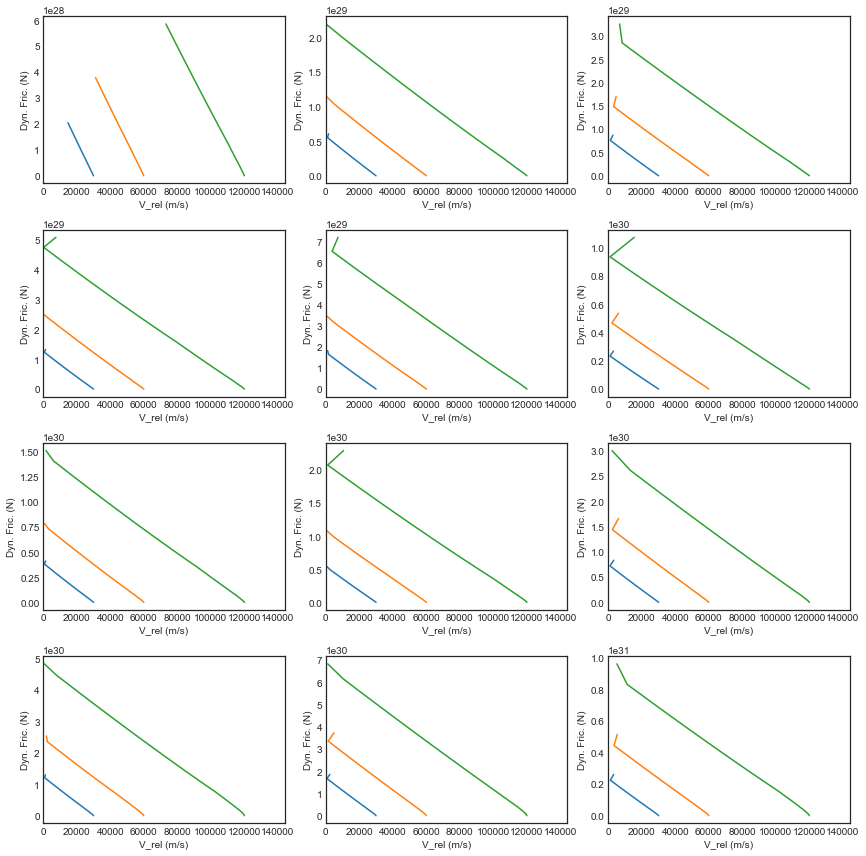

In [145]:
plt.style.use('seaborn-white')

# len(VPool)*len(MPool)*len(DPool)


figFV, FV_axes = plt.subplots(ncols=ND, nrows=NM, constrained_layout=True,figsize = (12,12))

plt.setp(FV_axes.flat, xlabel='V_rel (m/s)', ylabel='Dyn. Fric. (N)',xlim = (0,1.2*np.max(VPool)))

PlotNum = 0

for MassRow in range(NM):
    
    for DensityCol in range(ND):
                
        ax = FV_axes[MassRow,DensityCol]

        print(f"{PlotNum}")
        
        ax.plot(FV[:,PlotNum:PlotNum+NV],FA[:,PlotNum:PlotNum+NV])
        
        PlotNum += NV



figFV.tight_layout()
plt.show()

    

## V-T Plot

0
3
6
9
12
15
18
21
24
27
30
33


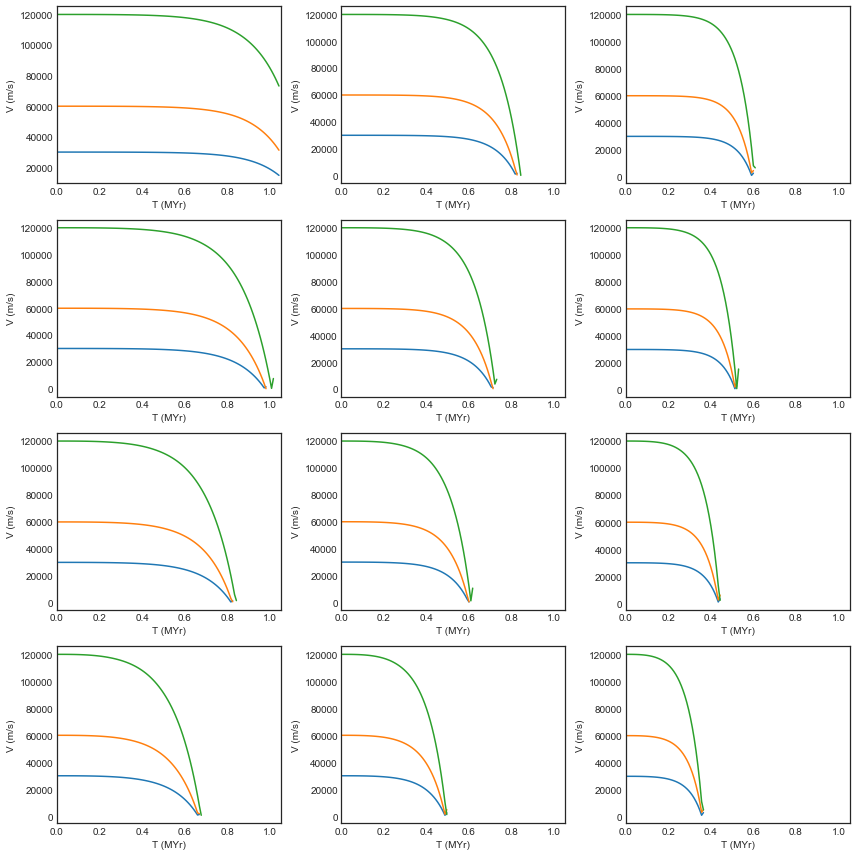

In [146]:
plt.style.use('seaborn-white')


figFV, FV_axes = plt.subplots(ncols=ND, nrows=NM, constrained_layout=True,figsize = (12,12))

plt.setp(FV_axes.flat, xlabel='T (MYr)', ylabel='V (m/s)',xlim = (0,durationMyr))

PlotNum = 0

for MassRow in range(NM):
    
    for DensityCol in range(ND):
        
        ax = FV_axes[MassRow,DensityCol]
        
        
        print(f"{PlotNum}")
        
        ax.plot(TpP,FV[:,PlotNum:PlotNum+NV])
        PlotNum += NV
figFV.tight_layout()
plt.show()

    

## Y-V "Phase Space" Plot

This is a dissipative system...

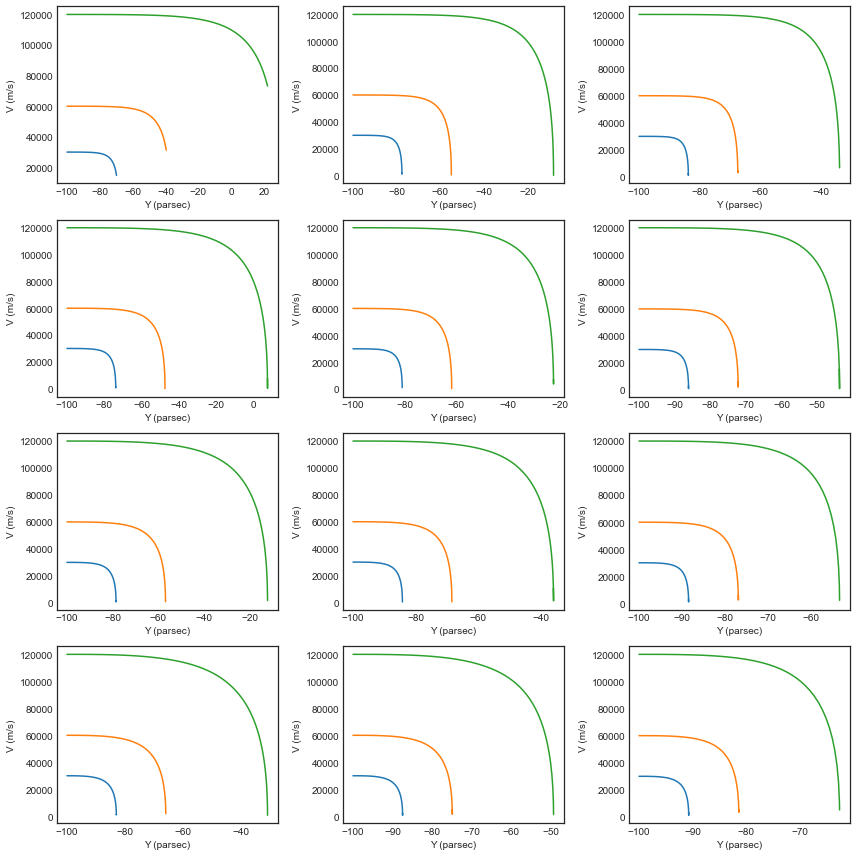

In [147]:
plt.style.use('seaborn-white')

figFV, FV_axes = plt.subplots(ncols=ND, nrows=NM, constrained_layout=True,figsize = (12,12))

plt.setp(FV_axes.flat, xlabel='Y (parsec)', ylabel='V (m/s)')

PlotNum = 0
for MassRow in range(NM):
    
    for DensityCol in range(ND):
        
        ax = FV_axes[MassRow,DensityCol]
               
        ax.plot(FY[:,PlotNum:PlotNum+NV],FV[:,PlotNum:PlotNum+NV])
        PlotNum += NV

figFV.tight_layout()
plt.show()    

## Energies

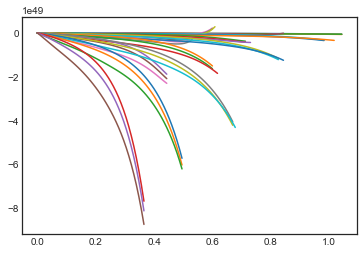

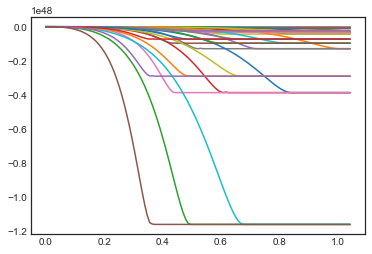

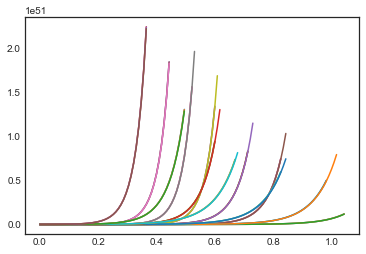

In [156]:
FEED = FEE - FEE[0,:]
FEND = FEN - FEN[0,:]
FEQD = FEQ - FEQ[0,:]

plt.figure()
plt.plot(TpP,FEED)

plt.figure()
plt.plot(TpP,FEND)

plt.figure()
plt.plot(TpP,FEQD)